# STA 220 Final Project Code
# Jake Tierney, Student ID: 913235409


In [1]:
# Importing requisite modules for this assignment
import requests as rq
import pandas as pd
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import warnings
from scipy.stats import f_oneway, linregress

# __Section 1__: Data Procurement

In [34]:
# Creating the range of years that we're interested in
years = range(1976, 2024)

# Creating an empty pandas df that we will store the final scraped data in
players_total = pd.DataFrame({
    'Year': [],
    'Name': [],
    'Page': [],
    'Age': [],
    'Team': [],
    'WAR': [],
    'oWAR': [],
    'dWAR': [],
    'Salary': [],
    'Acquired': [],
    'Position': []
}) 


# Iterating over every relevant year
for y in years:

    # Set the URL for the page containing player value data for that year
    url = 'https://www.baseball-reference.com/leagues/majors/' + str(y) + '-value-batting.shtml'

    # Requesting and parsing the data from that page
    response = rq.get(url)
    data = BeautifulSoup(response.text, 'html.parser')

    # Subsetting to only the player value table
    table = str(data.find('div', {'id': 'all_players_value_batting'}))
    players = table.split('</thead>')[1].split('<tr class="full_table" >')[1:]

    # Creating the vectors that will store player data for that year
    year = []
    names = []
    pages = []
    ages = []
    teams = []
    wars = []
    owars = []
    dwars = []
    salaries = []
    acqs = []
    positions = []

    # Iterating over every player in that year
    for p in range(0, len(players)):

        # Creating a dataset only for that player
        player = players[p].split('data-stat=')

        # Setting a threshold for plate appearances
        pa = player[6][player[6].find('" >') + 3:player[6].find('</td>')]
        if pa == "":
            pa = 0
        else:
            pa = int(player[6][player[6].find('" >') + 3:player[6].find('</td>')])
        if pa >= 162:

            # Defining player name, page url, and age
            name = player[2][player[2].find('csk=') + 5:player[2].find('0" >')]
            page = 'https://www.baseball-reference.com' + player[2][player[2].find('href=') + 6:player[2].find('.shtml">') + 6]
            age = player[3][player[3].find('0" >') + 4:player[3].find('</td')]

            # Conditionally defining player's team
            if 'href=' in player[4]:
                team = player[4][player[4].find('ml">') + 4:player[4].find('</a>')]
            else:
                team = player[4][player[4].find('>') + 1:player[4].find('</td>')]

            # Defining player's WAR, oWAR, and dWAR
            war = float(player[16][player[16].find('csk=') + 5:player[16].find('" >')])
            owar = float(player[19][player[19].find('csk=') + 5:player[19].find('" >')])
            dwar = float(player[20][player[20].find('csk=') + 5:player[20].find('" >')])

            # Conditionally defning player's salary
            if '$' in player[22]:
                salary = int(player[22][player[22].find('csk=') + 5:player[22].find('" >')])
            else:
                salary = 0

            # Defining how the player was acquired and their position
            acquired = player[23][player[23].find('" >') + 3:player[23].find('</td>')]
            position = player[24][player[24].find('" >') + 3:player[24].find('/') + 2]

            # Appending player data to the requisite vectors for that year
            names.append(name)
            pages.append(page)
            ages.append(age)
            teams.append(team)
            wars.append(war)
            owars.append(owar)
            dwars.append(dwar)
            salaries.append(salary)
            acqs.append(acquired)
            positions.append(position)
            year.append(y)

        # Skipping to next player if they don't meet the plate appearances threshold
        else:
            continue

    # Creating a pandas dataframe of that year's data
    players_year = pd.DataFrame({
        'Year': year,
        'Name': names,
        'Page': pages,
        'Age': ages,
        'Team': teams,
        'WAR': wars,
        'oWAR': owars,
        'dWAR': dwars,
        'Salary': salaries,
        'Acquired': acqs,
        'Position': positions
    })

    # Appending that year's data to the overall pandas dataframe
    players_total = pd.concat([players_total, players_year], ignore_index=True)

    # Resting in order to rate limit requests
    time.sleep(5)

In [3]:
# Writing the data table as a csv and loading that table for future use so we don't need to run the above code chunk every time
players_total.to_csv('players_total.csv', index = False)
players_total = pd.read_csv('/Users/Jake/Desktop/STA_220/Project/players_total.csv')

# __Section 2__: Data Processing

In [4]:
# PART (i): SPLITTING OUT ROWS WHERE PLAYERS PLAYED FOR MULTIPLE TEAMS

# Creating subset dataframe of players who played for multiple teams in a given season
mult = players_total[players_total['Team'].isin(['2TM', '3TM', '4TM'])]
mult.index = range(0, len(mult['Page']))

# Creating an empty pandas df that will store all of the final split out stats for each player
players_split_final = pd.DataFrame({
    'Year': [],
    'Name': [],
    'Page': [],
    'Age': [],
    'Team': [],
    'WAR': [],
    'oWAR': [],
    'dWAR': [],
    'Salary': [],
    'Acquired': [],
    'Position': []
})

# Iterating over every player in the mult dataframe
for p in range(0, len(mult['Page'])):
    
    # Getting data from player's reference page
    p_url = mult['Page'][p]
    player_rq = rq.get(p_url)
    player_data = str(BeautifulSoup(player_rq.text, 'html.parser'))
    player_data = player_data.replace('<strong>', '').replace('</strong>', '').replace('<em>', '').replace('</em>', '')

    # Subsetting to only the player value -- batting table
    batting_table = player_data.split('Player Value--Batting')[4].split('id=')[1:]

    # Creating a list containing only the relevant year for that player (in which they played for multiple teams)
    player_value_years = []
    for i in batting_table:
        if 'batting_value.' + str(int(mult['Year'][p])) in i:
            player_value_years.append(i)

    # Creating an empty pandas df that we will store the player's individual team data in
    player_split = pd.DataFrame({
        'Year': [],
        'Name': [],
        'Page': [],
        'Age': [],
        'Team': [],
        'WAR': [],
        'oWAR': [],
        'dWAR': [],
        'Salary': [],
        'Acquired': [],
        'Position': []
    })

    # iterating across each team that the player played for in that year
    for y in player_value_years:

        # Splitting out the data for that team in that year so that each statistic has its own row
        player_year = y.split('class=')
        if '"sr_star"></span></th><td ' in player_year:
            player_year.remove('"sr_star"></span></th><td ')

        # Conditionally including only players who had at least 162 plate appearances for a given team
        p_pa = int(player_year[7][player_year[7].find('" >') + 3:player_year[7].find('</td')])
        if p_pa >= 162:

            # Defining the variables for that player on that team in that year
            p_year = int(player_year[2][player_year[2].find('csk=') + 5:player_year[2].find('" >')])
            p_name = mult['Name'][p]
            p_page = p_url
            p_age = int(player_year[3][player_year[3].find('" >') + 3:player_year[3].find('</td')])
            p_team = player_year[4][player_year[4].find('">') + 2:player_year[4].find('</a>')]
            p_war = float(player_year[17][player_year[17].find('csk=') + 5:player_year[17].find('" >')])
            p_owar = float(player_year[20][player_year[20].find('csk=') + 5:player_year[20].find('" >')])
            p_dwar = float(player_year[21][player_year[21].find('csk=') + 5:player_year[21].find('" >')])
            if '$' in player_year[23]:
                p_salary = int(player_year[23][player_year[23].find('" >') + 3:player_year[23].find('</td')].replace('$', '').replace(',', ''))
            else:
                p_salary = 0
            p_acq = mult['Acquired'][p]
            p_pos = player_year[24][player_year[24].find('" >') + 3:player_year[24].find('/') + 2]
            
            # Creating a pandas dataframe of that team/year's data
            player_year_final = pd.DataFrame({
                'Year': p_year,
                'Name': p_name,
                'Page': p_page,
                'Age': p_age,
                'Team': p_team,
                'WAR': p_war,
                'oWAR': p_owar,
                'dWAR': p_dwar,
                'Salary': p_salary,
                'Acquired': p_acq,
                'Position': p_pos
            }, index = ['1'])
            
            # Appending that year's data to the overall pandas dataframe for that player
            player_split = pd.concat([player_split, player_year_final], ignore_index=True)
    
        else:
            continue

    # Appending the player's split data for each year to the final players_split dataframe
    players_split_final = pd.concat([players_split_final, player_split], ignore_index = True)

    # Resting for 5 seconds to rate limit requests
    time.sleep(5)

In [4]:
# Writing the data table as a csv and loading that table for future use so we don't need to run the above code chunk every time
players_split_final.to_csv('players_split_final.csv', index = False)
players_split_final = pd.read_csv('/Users/Jake/Desktop/STA_220/Project/players_split_final.csv')

# Replacing any rows in players_total where the player played for multiple teams with their splits via players_split_final
players_total_filter = players_total[~players_total['Team'].isin(['2TM', '3TM', '4TM'])]
df_final = pd.concat([players_total_filter, players_split_final], ignore_index=True)

In [5]:
# PART (ii): REPLACING SALARIES OF 0.0 WITH THE VET MINIMUM MLB SALARY FOR EACH YEAR

# Getting minimum salary data for each year from 1967-2021 from baseball almanac
almanac = 'https://www.baseball-almanac.com/charts/salary/major_league_salaries.shtml'
heads = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36'}
alm_resp = rq.get(almanac, headers = heads)
alm_data = str(BeautifulSoup(alm_resp.text, 'html.parser')).split('<strong>MLB Minimum Wage Data</strong>')[1].split('align="center"')
alm_data = alm_data[3:113]

# Creating vectors for the year and the minimum salary in that year
years = []
mins = []
for r in alm_data:
    if '$' in r:
        min = int(r[r.find('>') + 1:r.find('</')].replace('$', '').replace(',', '').replace(' *', ''))
        mins.append(min)
    else:
        years.append(float(r[r.find('>') + 1:r.find('</')]))
        continue

# Manually coding in 2022 and 2023 minimum salaries
years.append(2022)
years.append(2023)
mins.append(700000)
mins.append(720000)

# Creating a pandas dataframe containing minimum MLB salaries for each year
minimum_salaries = pd.DataFrame({
    'Year': years,
    'Minimum': mins
})

# Replacing 0.0 salaries with the vet minimum MLB salary for that season
warnings.filterwarnings("ignore")
for i in range(0, len(df_final['Salary'])):
    if df_final['Salary'][i] == 0.0:
        df_final['Salary'][i] = minimum_salaries['Minimum'][minimum_salaries['Year'] == df_final['Year'][i]]

In [6]:
# PART (iii): TRIMMING THE POSITION VARIABLE TO JUST THE PLAYER'S PRIMARY POSITION

# Iterating over every player in df_final
for i in range(0, len(df_final['Position'])):

    # Conditionally slicing the position variable for each player to include only the first non-pinch-hitter position listed
    if '/' in df_final['Position'][i] and df_final['Position'][i].index('/') == 0:
        df_final['Position'][i] = df_final['Position'][i][1]
    elif '*' in df_final['Position'][i] and df_final['Position'][i].index('*') == 0:
        df_final['Position'][i] = df_final['Position'][i][1]
    elif 'H' in df_final['Position'][i] and df_final['Position'][i].index('H') == 0:
        df_final['Position'][i] = df_final['Position'][i][1]
    else:
        df_final['Position'][i] = df_final['Position'][i][0]     

In [7]:
# PART (iv): CREATING AGGREGATED GROUPS FOR PLAYER ACQUISITION METHOD

# Grouping all 'Draft' methods of acquisition
drafts = ['1st Yr Draft', 'Amateur Draft', 'Amateur Draft--no sign', 'Drafted--FA Comp', 'Expansion Draft', 'MinorLg Draft',
         'Rule 5 Draft', 'Rule 5 returned']
rep_draft = 'Draft'
df_final['Acquired'] = df_final['Acquired'].replace(drafts, rep_draft)
df_final['Acquired'] = df_final['Acquired'].fillna('Draft')

# Grouping all 'Free Agency' methods of acquisition
fa = ['Amateur Free Agent', 'Free Agency', 'Purchased', 'Purchased--voided', 'Waivers']
rep_fa = 'Free Agency'
df_final['Acquired'] = df_final['Acquired'].replace(fa, rep_fa)

# Grouping all 'Trade' methods of acquisition
trade = ['Conditional Deal', 'Traded', 'Traded--return']
rep_trade = 'Trade'
df_final['Acquired'] = df_final['Acquired'].replace(trade, rep_trade)

In [8]:
# PART (v): UPDATING OUTDATED TEAM CODES

# Reclassifying outdated team codes as their modern-day counterparts
df_final['Team'][df_final['Team'] == 'CAL'] = 'LAA'
df_final['Team'][df_final['Team'] == 'ANA'] = 'LAA'
df_final['Team'][df_final['Team'] == 'MON'] = 'WSN'
df_final['Team'][df_final['Team'] == 'FLA'] = 'MIA'
df_final['Team'][df_final['Team'] == 'TBD'] = 'TBR'

In [9]:
# Writing the data table as a csv and loading that table for future use so we don't need to run the above code chunks every time
df_final.to_csv('df_final.csv', index = False)
df_final = pd.read_csv('/Users/Jake/Desktop/STA_220/Project/df_final.csv')

# __Section 3__: Data Analysis

In [10]:
# What position was the most valuable between 1976 and 2023 (total WAR)?
# Has positional value changed over time? (Group by 12/16 year periods)?

# Creating a list of unique positions
warnings.filterwarnings("ignore")
df_final['Position'][df_final['Position'] == '/'] = '7'
df_final['Position'][df_final['Position'] == 'H'] = '9'
positions = list(set(df_final['Position']))

# Creating subsets of the dataframe corresponding to 12 year periods
df_7687 = df_final[df_final['Year'] <= 1987.0]
df_8899 = df_final[df_final['Year'] >= 1988.0]
df_8899 = df_8899[df_8899['Year'] <= 1999.0]
df_0011 = df_final[df_final['Year'] >= 2000.0]
df_0011 = df_0011[df_0011['Year'] <= 2011.0]
df_1223 = df_final[df_final['Year'] >= 2012.0]


# For each position, what is the total WAR
pos_war_total = []
pos_war_7687 = []
pos_war_8899 = []
pos_war_0011 = []
pos_war_1223 = []
for p in positions:
    pw_total = round(sum(df_final['WAR'][df_final['Position'] == p]), 2)
    pos_war_total.append(pw_total)
    pw_7687 = round(sum(df_7687['WAR'][df_7687['Position'] == p]), 2)
    pos_war_7687.append(pw_7687)
    pw_8899 = round(sum(df_8899['WAR'][df_8899['Position'] == p]), 2)
    pos_war_8899.append(pw_8899)
    pw_0011 = round(sum(df_0011['WAR'][df_0011['Position'] == p]), 2)
    pos_war_0011.append(pw_0011)
    pw_1223 = round(sum(df_1223['WAR'][df_1223['Position'] == p]), 2)
    pos_war_1223.append(pw_1223)

# Creating pandas dataframe from the position variable and WAR for that position
pw_df = pd.DataFrame({
    'Position': positions,
    'WAR Total': pos_war_total,
    'WAR 1976-87': pos_war_7687,
    'WAR 1988-99': pos_war_8899,
    'WAR 2000-11': pos_war_0011,
    'WAR 2012-23': pos_war_1223,
}) 

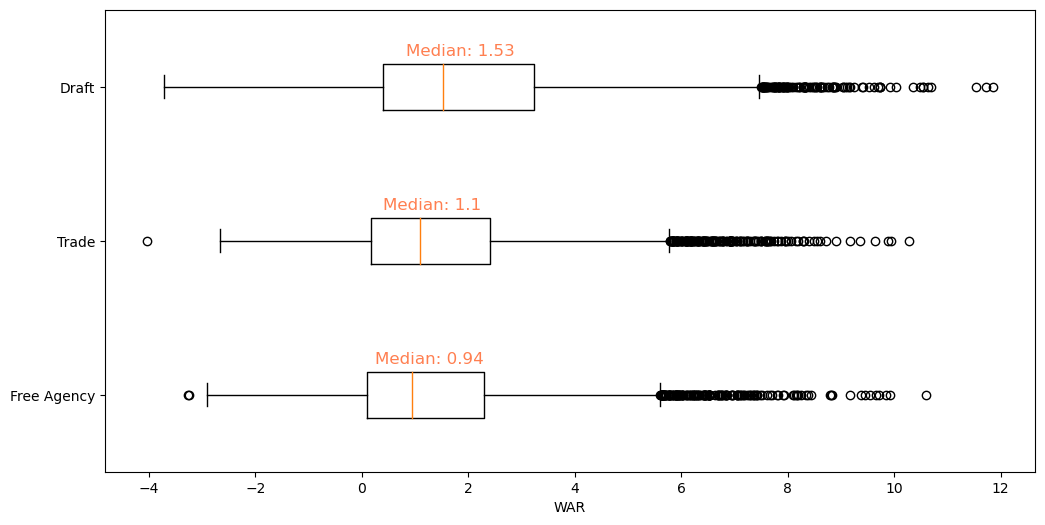

In [11]:
# Is the method in which a player is acquired associated with WAR (grouped boxplots/strip plot)?

# Storing the median WAR for each acquisition method
med_draft = df_final['WAR'][df_final['Acquired'] == 'Draft'].median()
med_trade = df_final['WAR'][df_final['Acquired'] == 'Trade'].median()
med_fa = df_final['WAR'][df_final['Acquired'] == 'Free Agency'].median()

# Creating grouped boxplots
grouped_df = df_final.groupby('Acquired')['WAR']
plt.figure(figsize=(12, 6))
plt.boxplot([grouped_df.get_group('Free Agency'), grouped_df.get_group('Trade'), grouped_df.get_group('Draft')],
            labels=['Free Agency', 'Trade', 'Draft'], vert = False);
plt.text(med_draft - 0.7, 3.2, 'Median: ' + str(med_draft), fontsize=12, color='coral')
plt.text(med_trade - 0.7, 2.2, 'Median: ' + str(med_trade), fontsize=12, color='coral')
plt.text(med_fa - 0.7, 1.2, 'Median: ' + str(med_fa), fontsize=12, color='coral')
plt.xlabel('WAR')
plt.savefig('boxplots.png');

In [12]:
# One-Way Anova to determine if there are significant differences in mean WAR between acquisition methods
f_statistic, p_value = f_oneway(grouped_df.get_group('Free Agency'), grouped_df.get_group('Trade'), grouped_df.get_group('Draft'))
results1 = 'One-Way ANOVA F Statistic: ' + str(round(f_statistic, 4))
results2 = 'One-Way ANOVA P-Value: ' + str(round(p_value, 4))
print(results1)
print(results2)

One-Way ANOVA F Statistic: 177.6229
One-Way ANOVA P-Value: 0.0


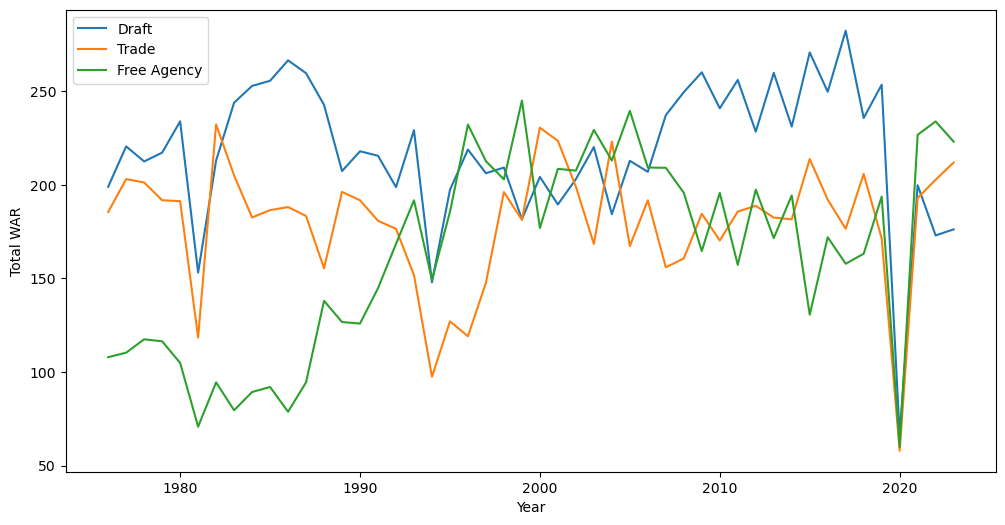

In [13]:
# Does WAR by acquisition method change over time (time series plot with three lines)?

# Creating list of years to form the X variable of our time series
years = list(set(df_final['Year']))

# Creating time series for total WAR per year among Drafted players
df_draft = df_final[df_final['Acquired'] == 'Draft']
w_draft = []
for y in years:
    w_d_year = round(sum(df_draft['WAR'][df_draft['Year'] == y]), 2)
    w_draft.append(w_d_year)
    
# Creating time series for total WAR per year among Traded players
df_trade = df_final[df_final['Acquired'] == 'Trade']
w_trade = []
for y in years:
    w_t_year = round(sum(df_trade['WAR'][df_trade['Year'] == y]), 2)
    w_trade.append(w_t_year)

# Creating time series for total WAR per year among Free Agent players
df_fa = df_final[df_final['Acquired'] == 'Free Agency']
w_fa = []
for y in years:
    w_f_year = round(sum(df_fa['WAR'][df_fa['Year'] == y]), 2)
    w_fa.append(w_f_year)

# Creating pandas dataframe from the year variable and time series
acq_ts = pd.DataFrame({
    'Year': years,
    'Draft WAR': w_draft,
    'Trade WAR': w_trade,
    'Free Agency WAR': w_fa
})

# Plotting the time series plot
plt.figure(figsize=(12, 6))
plt.plot(acq_ts['Year'], acq_ts['Draft WAR'], label='Draft')
plt.plot(acq_ts['Year'], acq_ts['Trade WAR'], label='Trade')
plt.plot(acq_ts['Year'], acq_ts['Free Agency WAR'], label='Free Agency')
plt.xlabel('Year')
plt.ylabel('Total WAR')
plt.legend()
plt.savefig('timeseries.png');

In [14]:
# Which teams have the best total WAR from 1976-2023, which have the worst?
# Which teams have been most efficient at accruing WAR ($ per WAR), which have been the least efficient?
# Scatterplot of team spending (X-Axis) vs. total WAR (Y-Axis)

# Creating vectors for each of team code, total war, total salary, and salary to war ratio
teams = list(set(df_final['Team']))
team_war = []
team_salary = []
team_ratio = []
for t in teams:
    t_war = sum(df_final['WAR'][df_final['Team'] == t])
    t_sal = round(sum(df_final['Salary'][df_final['Team'] == t])/1000000, 2)
    t_ratio = t_sal/t_war
    team_war.append(t_war)
    team_salary.append(t_sal)
    team_ratio.append(t_ratio)

# Creating pandas dataframe from the team variable and total war variable
team_df = pd.DataFrame({
    'Team': teams,
    'Total WAR': team_war,
    'Total Salary (Millions)': team_salary,
    'Salary per WAR (Millions)': team_ratio
})

# Sorting by total WAR and salary to WAR ratio
team_df_WAR = team_df.sort_values(by='Total WAR', ascending=False)
team_df_ratio = team_df.sort_values(by='Salary per WAR (Millions)', ascending=True)

# Creating a dataframe of the top five and bottom five teams as it pertains to total WAR
top_bottom_WAR = pd.concat([team_df_WAR[0:5], team_df_WAR[len(team_df_WAR['Team']) - 5:]], ignore_index=True)

# Creating a dataframe of the top five and bottom five teams as it pertains to ratio
top_bottom_ratio = pd.concat([team_df_ratio[0:5], team_df_ratio[len(team_df_ratio['Team']) - 5:]], ignore_index=True)

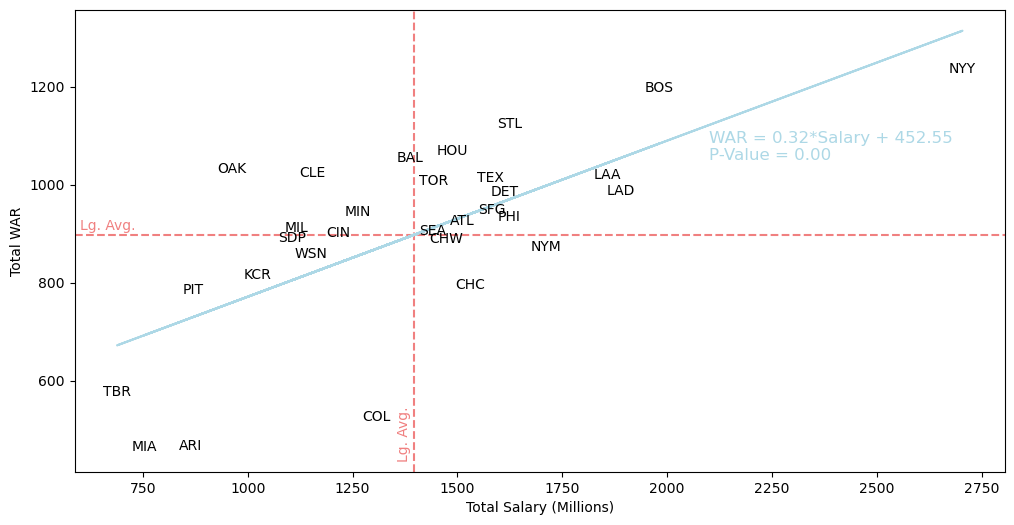

In [31]:
# Is there a linear relationship between team total salary and WAR?

# Creating a dataframe consisting only of team code, Total WAR, and Total Spending
data = pd.DataFrame({
    'Team': team_df['Team'],
    'Total WAR': team_df['Total WAR'],
    'Total Salary (Millions)': team_df['Total Salary (Millions)']
})

# Plotting the scatterplot of total salary vs total war
plt.figure(figsize=(12, 6))
x = team_df['Total Salary (Millions)']
y = team_df['Total WAR']
plt.scatter(x, y, alpha = 0)
#plt.title('Team Total Salary vs WAR, 1976 - 2023')
plt.xlabel('Total Salary (Millions)')
plt.ylabel('Total WAR')
plt.axvline(x=x.mean(), color='lightcoral', linestyle='--')
plt.axhline(y=y.mean(), color='lightcoral', linestyle='--')
plt.text(600,y.mean() + 10, 'Lg. Avg.', color = 'lightcoral')
plt.text(x.mean() - 40, 440, 'Lg. Avg.', color = 'lightcoral', rotation = 'vertical')

# Calculate linear regression and plot the line and equation
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color='lightblue')
equation = f'WAR = {slope:.2f}*Salary + {intercept:.2f}\nP-Value = {p_value:.2f}'
plt.text(2100, 1050, equation, fontsize=12, color='lightblue')

# Placing the team label on each data point
labels = team_df['Team']
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,0), ha='center')
plt.savefig('scatterplot.png');